In [2]:
import os
import random
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

# === Parameters ===
IMAGE_SIZE = 128
SHAPE_SIZE = 60
NUM_IMAGES_PER_CLASS = 300
OUTPUT_DIR = "fixed_length_fixed_rotation"
SHAPES = ["circle", "square", "triangle"]
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Drawing Functions ===
def draw_shape(shape, image_size, shape_size, rotation=0):
    img = Image.new("RGB", (image_size, image_size), "white")
    draw = ImageDraw.Draw(img)
    center = (image_size // 2, image_size // 2)
    half = shape_size // 2

    if shape == "circle":
        bbox = [center[0]-half, center[1]-half, center[0]+half, center[1]+half]
        draw.ellipse(bbox, fill="black")
    elif shape == "square":
        bbox = [center[0]-half, center[1]-half, center[0]+half, center[1]+half]
        square = Image.new("L", (image_size, image_size), 0)
        ImageDraw.Draw(square).rectangle(bbox, fill=255)
        square = square.rotate(rotation, expand=False)
        img.paste("black", mask=square)
    elif shape == "triangle":
        triangle = Image.new("L", (image_size, image_size), 0)
        points = [
            (center[0], center[1]-half),
            (center[0]-half, center[1]+half),
            (center[0]+half, center[1]+half)
        ]
        ImageDraw.Draw(triangle).polygon(points, fill=255)
        triangle = triangle.rotate(rotation, expand=False)
        img.paste("black", mask=triangle)
    return img

# === Generate Images ===
for shape in SHAPES:
    shape_dir = os.path.join(OUTPUT_DIR, shape)
    os.makedirs(shape_dir, exist_ok=True)
    for i in range(NUM_IMAGES_PER_CLASS):
        img = draw_shape(shape, IMAGE_SIZE, SHAPE_SIZE, rotation=0)
        img.save(os.path.join(shape_dir, f"{shape}_{i}.png"))


In [1]:
import sys
print(sys.executable)


d:\First_project\.venv\Scripts\python.exe


In [4]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import os
from PIL import Image

# === Transformations ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # converts to [0,1]
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize to [-1,1]
])

# === Custom Dataset ===
class ShapeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.labels = {"circle": 0, "square": 1, "triangle": 2}
        self.transform = transform
        for shape_name, label in self.labels.items():
            shape_dir = os.path.join(root_dir, shape_name)
            for img_file in os.listdir(shape_dir):
                if img_file.endswith(".png"):
                    self.samples.append((os.path.join(shape_dir, img_file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# === Load Full Dataset ===
dataset = ShapeDataset("fixed_length_fixed_rotation", transform=transform)

# === Split Dataset ===
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# === Create DataLoaders ===
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)


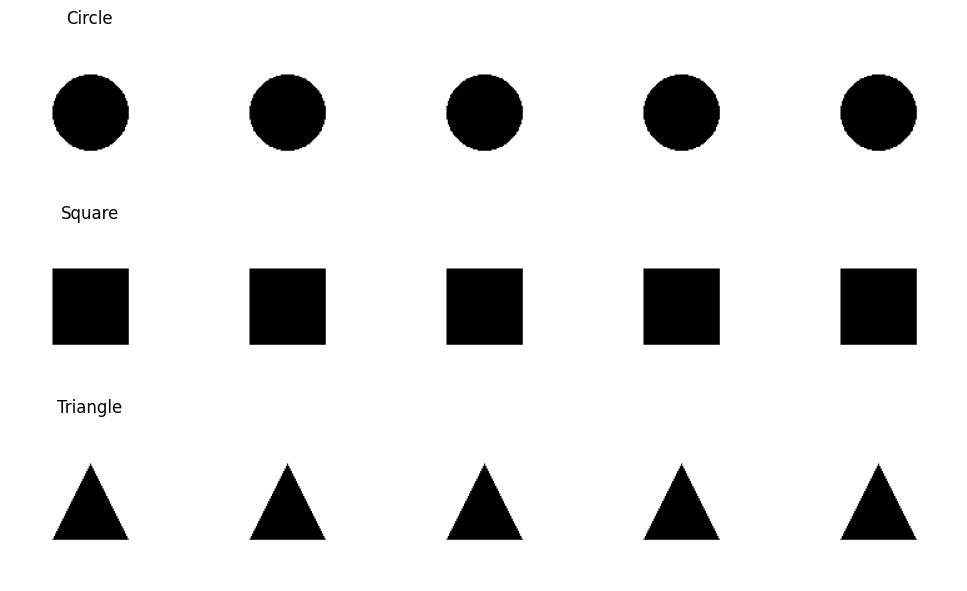

In [5]:
import matplotlib.pyplot as plt

def show_samples(dataset, num_samples=5):
    fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))
    labels_map = {0: 'Circle', 1: 'Square', 2: 'Triangle'}
    counts = {0: 0, 1: 0, 2: 0}

    for img, label in dataset:
        if counts[label] < num_samples:
            ax = axs[label, counts[label]]
            ax.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)  # unnormalize
            ax.axis('off')
            if counts[label] == 0:
                ax.set_title(labels_map[label])
            counts[label] += 1
        if all(v == num_samples for v in counts.values()):
            break
    plt.tight_layout()
    plt.show()

# Show samples from the training dataset
show_samples(train_set)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # 128x128x3 → 128x128x16
        self.pool1 = nn.MaxPool2d(2, 2)                           # → 64x64x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # → 64x64x32
        self.pool2 = nn.MaxPool2d(2, 2)                           # → 32x32x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # → 32x32x64
        self.pool3 = nn.MaxPool2d(2, 2)                           # → 16x16x64

        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Using device: cuda


100%|██████████| 20/20 [00:00<00:00, 24.48it/s]


[Epoch 1/15] Train Loss: 0.3114 | Val Loss: 0.0004 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 24.49it/s]


[Epoch 2/15] Train Loss: 0.0001 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


[Epoch 3/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 24.49it/s]


[Epoch 4/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 24.48it/s]


[Epoch 5/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 25.00it/s]


[Epoch 6/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 25.00it/s]


[Epoch 7/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 25.08it/s]


[Epoch 8/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 24.50it/s]


[Epoch 9/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 24.32it/s]


[Epoch 10/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 23.78it/s]


[Epoch 11/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 24.85it/s]


[Epoch 12/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 24.94it/s]


[Epoch 13/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 25.00it/s]


[Epoch 14/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


100%|██████████| 20/20 [00:00<00:00, 25.08it/s]


[Epoch 15/15] Train Loss: 0.0000 | Val Loss: 0.0000 | Val Acc: 100.00%


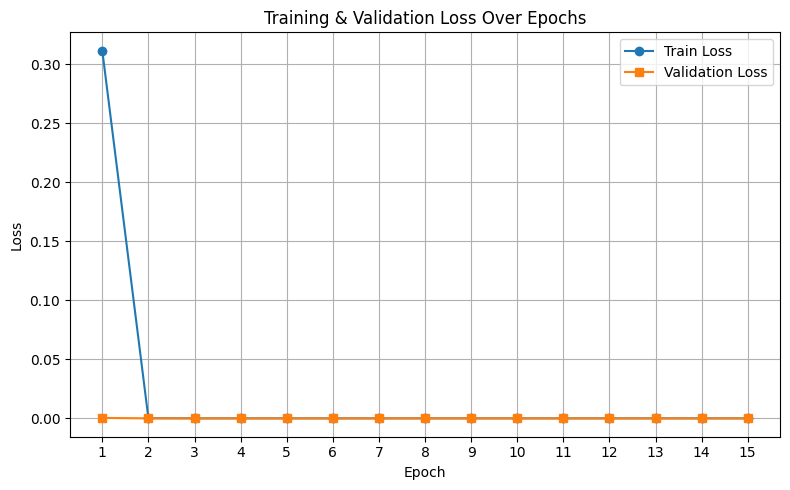

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# === Device Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Model, Loss, Optimizer ===
model = SimpleCNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Training Settings ===
num_epochs = 15
train_losses = []
val_losses = []

# === Training Loop ===
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # === Validation ===
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {100 * correct / total:.2f}%")

import matplotlib.pyplot as plt

# === Plot Training and Validation Loss ===
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='s')
plt.title("Training & Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()

# === Save to file (optional)
plt.savefig("ShapeClassifierPyTorch/images/loss_curve_fixed_fixed.png")  # Make sure 'images/' exists
plt.show()


✅ Test Accuracy: 100.00%


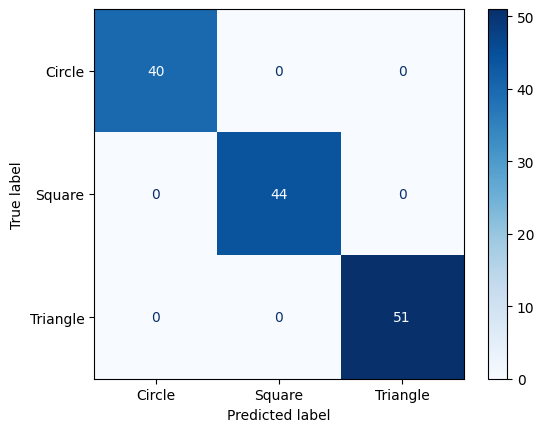

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Circle", "Square", "Triangle"])
disp.plot(cmap="Blues")


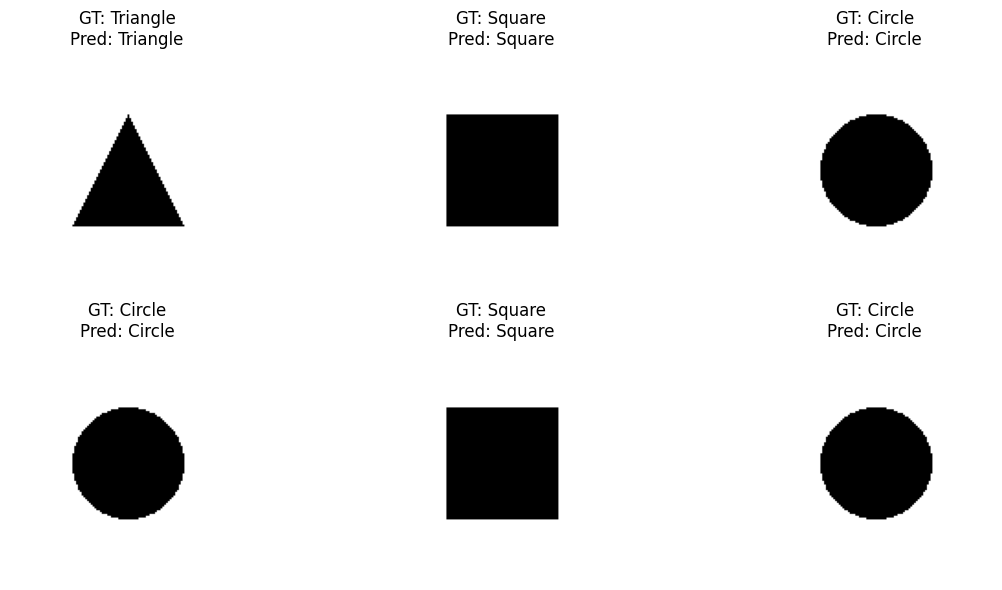

In [9]:
import matplotlib.pyplot as plt

# === Reverse label map
label_map = {0: "Circle", 1: "Square", 2: "Triangle"}

# === Show predictions on a batch of test images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot first 6 predictions
plt.figure(figsize=(12, 6))
for i in range(6):
    img = images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
    plt.subplot(2, 3, i+1)
    plt.imshow(img.numpy())
    plt.title(f"GT: {label_map[labels[i].item()]}\nPred: {label_map[preds[i].item()]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw
import random
from tqdm import tqdm

# === Configuration ===
SAVE_ROOT = "fixed_length_random_rotation"
IMAGE_SIZE = 64
SHAPE_SIZE = 30  # fixed size for all shapes
NUM_SAMPLES = 500

os.makedirs(SAVE_ROOT, exist_ok=True)

SHAPE_CLASSES = ["circle", "square", "triangle"]
for shape in SHAPE_CLASSES:
    os.makedirs(os.path.join(SAVE_ROOT, shape), exist_ok=True)


def generate_shape_image(shape_name, idx):
    img = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE), "white")
    draw = ImageDraw.Draw(img)

    center = (IMAGE_SIZE // 2, IMAGE_SIZE // 2)
    r = SHAPE_SIZE

    if shape_name == "circle":
        bbox = [center[0] - r, center[1] - r, center[0] + r, center[1] + r]
        draw.ellipse(bbox, fill="black")

    elif shape_name == "square":
        bbox = [center[0] - r, center[1] - r, center[0] + r, center[1] + r]
        draw.rectangle(bbox, fill="black")

    elif shape_name == "triangle":
        p1 = (center[0], center[1] - r)
        p2 = (center[0] - r, center[1] + r)
        p3 = (center[0] + r, center[1] + r)
        draw.polygon([p1, p2, p3], fill="black")

    # Apply random rotation
    angle = random.uniform(0, 360)
    img = img.rotate(angle, resample=Image.BICUBIC, fillcolor="white")

    save_path = os.path.join(SAVE_ROOT, shape_name, f"{idx}.png")
    img.save(save_path)


# === Generate ===
for shape in SHAPE_CLASSES:
    for i in tqdm(range(NUM_SAMPLES), desc=f"Generating {shape}"):
        generate_shape_image(shape, i)


Generating triangle: 100%|██████████| 500/500 [00:00<00:00, 1268.45it/s]


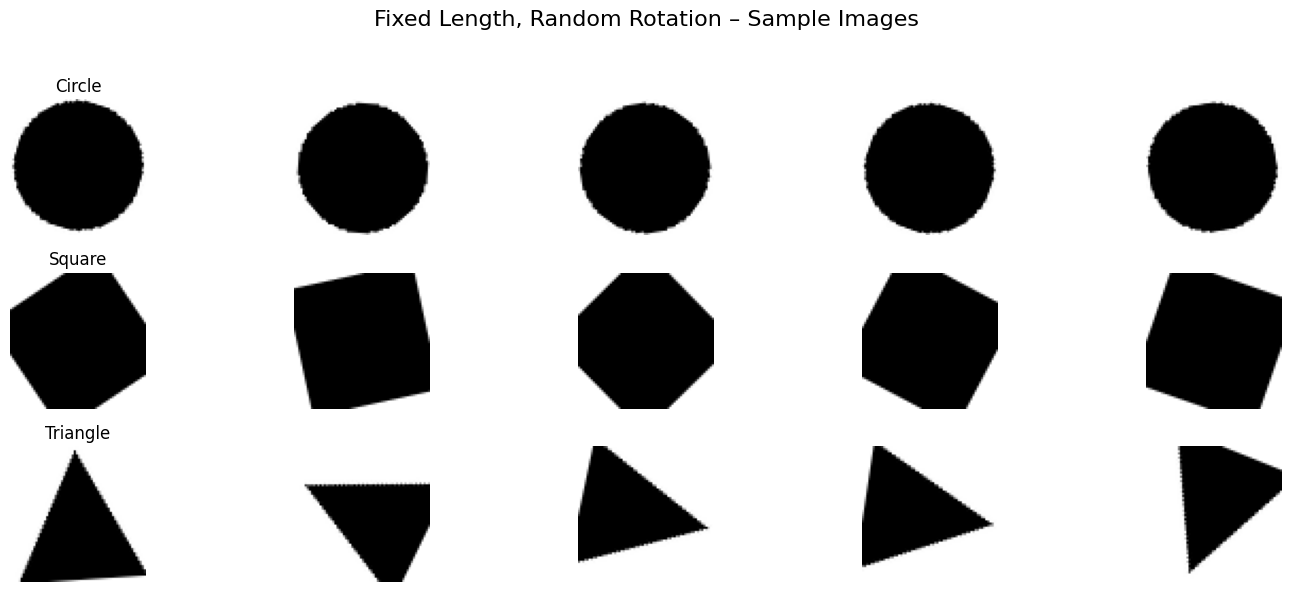

In [3]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# === Paths ===
DATASET_DIR = "fixed_length_random_rotation"
CLASSES = ["circle", "square", "triangle"]
NUM_SAMPLES_PER_CLASS = 5

# === Plot Setup ===
fig, axes = plt.subplots(len(CLASSES), NUM_SAMPLES_PER_CLASS, figsize=(15, 6))
fig.suptitle("Fixed Length, Random Rotation – Sample Images", fontsize=16)

for row, cls in enumerate(CLASSES):
    cls_dir = os.path.join(DATASET_DIR, cls)
    samples = random.sample(os.listdir(cls_dir), NUM_SAMPLES_PER_CLASS)
    for col, img_name in enumerate(samples):
        img_path = os.path.join(cls_dir, img_name)
        img = Image.open(img_path)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(cls.capitalize(), fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("images/fixed_length_random_rotation_samples.png")
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os

# === Config ===
DATA_DIR = "fixed_length_random_rotation"
CLASSES = ["Circle", "Square", "Triangle"]
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# === Dataset ===
class ShapeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label, cls in enumerate(CLASSES):
            cls_dir = os.path.join(root_dir, cls)
            for fname in os.listdir(cls_dir):
                if fname.endswith('.png'):
                    self.samples.append((os.path.join(cls_dir, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# === Model ===
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Linear(64, NUM_CLASSES)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# === Load dataset and split ===
full_dataset = ShapeDataset(DATA_DIR, transform=transform)
n_total = len(full_dataset)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_set, val_set, test_set = random_split(full_dataset, [n_train, n_val, n_test])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# === Training ===
model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # === Validation ===
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    acc = correct / total
    val_acc = val_correct / val_total
    print(f"[Epoch {epoch+1}/{EPOCHS}] Loss: {train_loss:.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")

# === Save model ===
torch.save(model.state_dict(), "shape_classifier.pth")
print("✅ Training complete and model saved.")


[Epoch 1/20] Loss: 30.8800 | Train Acc: 0.4752 | Val Acc: 1.0000
[Epoch 2/20] Loss: 14.6674 | Train Acc: 0.9248 | Val Acc: 0.9378
[Epoch 3/20] Loss: 4.7746 | Train Acc: 0.9771 | Val Acc: 1.0000
[Epoch 4/20] Loss: 1.7724 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 5/20] Loss: 0.6943 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 6/20] Loss: 0.3678 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 7/20] Loss: 0.2436 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 8/20] Loss: 0.1569 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 9/20] Loss: 0.1155 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 10/20] Loss: 0.0879 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 11/20] Loss: 0.0683 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 12/20] Loss: 0.0560 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 13/20] Loss: 0.0458 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 14/20] Loss: 0.0383 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 15/20] Loss: 0.0327 | Train Acc: 1.0000 | Val Acc: 1.0000
[Epoch 16/20] Loss: 0.0281 | Tra

In [10]:

# === Load model ===
model = SimpleCNN().to(DEVICE)
model.load_state_dict(torch.load("shape_classifier.pth"))
model.eval()

# === Evaluate ===
correct = 0
total = 0
class_correct = [0] * len(CLASSES)
class_total = [0] * len(CLASSES)

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        for i in range(len(labels)):
            label = labels[i]
            pred = preds[i]
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1

print(f"\n🎯 Overall Test Accuracy: {correct / total:.4f} ({correct}/{total})")

# === Per-class accuracy ===
print("\n📊 Per-Class Accuracy:")
for i, cls in enumerate(CLASSES):
    acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"{cls}: {acc:.4f} ({class_correct[i]}/{class_total[i]})")



🎯 Overall Test Accuracy: 1.0000 (225/225)

📊 Per-Class Accuracy:
Circle: 1.0000 (76/76)
Square: 1.0000 (70/70)
Triangle: 1.0000 (79/79)


C:\Users\User\AppData\Local\Temp\ipykernel_40168\238067481.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("shape_classifier.pth"))


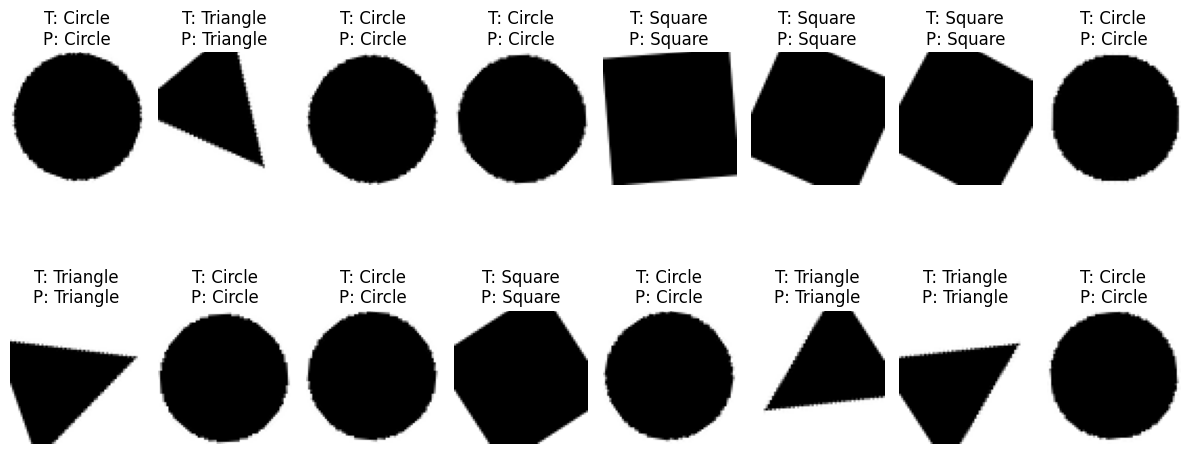

In [17]:
import matplotlib.pyplot as plt

# === Class names ===
CLASSES = ["Circle", "Square", "Triangle"]

# === Visualize one batch from test loader ===
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = model(imgs.to(DEVICE))
        preds = torch.argmax(outputs, dim=1).cpu()
        imgs = imgs.cpu()
        labels = labels.cpu()
        break  # only one batch

# === Plot ===
plt.figure(figsize=(12, 6))
for i in range(len(imgs)):
    img = imgs[i].permute(1, 2, 0).numpy()
    true_label = CLASSES[labels[i]]
    pred_label = CLASSES[preds[i]]
    plt.subplot(2, 8, i + 1)
    plt.imshow(img)
    plt.title(f"T: {true_label}\nP: {pred_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()
